In [359]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Dropout
import tensorflow as tf
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import unicodedata
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
stopwords = set(stopwords.words('english'))
import glob
# spacy for lemmatization
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.stem import SnowballStemmer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
#hyperparameters
vocab_size = 10000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [130]:
# stopwords
stop_words = stopwords
extra_stopwords = ['even','the','said','say','shares','person','useful','govtech','cio','yonhap','size','tackle','right','day','tried','tested','make','sure','used','help','yesterday','today','tomorrow','percent','per', 'cent','could','many','add','use','need','goods','million','thousand','company','retailers','saw','see','new','like','today','tomorrow','guide',
 'people','want','yet','way','time','back','whether','if','yes','older','noted','went','told','tell','younger','another','worth','noting','well','called','named','never','lee','quah','ong','ng','lim','tan','shared','says','say','said','cio', 'cios','month','top','world','zero','one','two','three','four','five','six','seven','eight','nine','ten','january', 'february', 'march', 'april', 'may', 'june', 'july',
              'august', 'september', 'october', 'november', 'december','month','months','years','year','near','also','would','able']
for word in extra_stopwords:
    stop_words.add(word)

In [439]:
path2 ='../data/test/'
filenames = glob.glob(path2 + "/*.csv")
test=[]
for file in filenames:
    print(file)
    d = pd.read_csv(file)
    test.append(d)
testset = pd.concat(test, ignore_index=True)

../data/test/test_set2.csv


In [131]:
path2 ='../data'
filenames = glob.glob(path2 + "/*.csv")

dfs = []
for filename in filenames:
    print(filename)
    df = pd.read_csv(filename, index_col=0)
#     df['source'] =re.search('\/([A-Za-z]+)[0-9]?\.csv',filename)[1]
    dfs.append(df)

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)
big_frame.head()

../data/training_set5.csv
../data/training_set4.csv
../data/training_set6.csv
../data/training_set7.csv
../data/training_set3.csv
../data/training_set1.csv


,title,imgurl,date,blurp,url,text,category,source
0,Meta Has Developed AI for Real-Time Translatio...,https://i.kinja-img.com/gawker-media/image/upl...,19/10/2022,Meta is chugging along on their Universal Spee...,https://gizmodo.com/meta-ai-language-translate...,Meta is chugging along on their Universal Spee...,artificial intelligence,gizmodo.com
1,Conservationists are using artificial intellig...,https://i.insider.com/6351bad5ffcac3001876a295...,21/10/2022,Conservationists are using artificial intellig...,https://www.businessinsider.com/scientists-use...,Researchers and scientists are using artificia...,artificial intelligence,business insider
2,U.S. scientist hits another dead end in patent...,https://www.reuters.com/resizer/ip351LvvKBOZe9...,20/10/2022,A U.S. computer scientist on Thursday lost his...,https://www.reuters.com/legal/litigation/us-sc...,Summary\n\nSummary Law firms Stephen Thaler ar...,artificial intelligence,reuters
3,AI can't hold patents to U.S. inventions (for ...,https://www.reuters.com/resizer/N4Lp7g4kueV4j8...,20/10/2022,"Three years ago, Stephen Thaler filed two pate...",https://www.reuters.com/legal/legalindustry/ai...,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nOctober 20, 2022 -...",artificial intelligence,reuters
4,The ‘M3GAN’ Dance Meme: Vicious Dolls Could Do...,https://media.wired.com/photos/6351d95de5ba9e0...,21/10/2022,Fans have been recutting the film’s trailer to...,https://www.wired.com/story/m3gan-meme-twitter...,NaN,artificial intelligence,wired


In [132]:
def thorough_cleaning(text):
    text = ''.join(text)
    text = text.strip()
    text = " ".join(text.split())
    text = re.sub("[^0-9a-zA-Z]"," ", text)
    text = re.sub('[0-9]{2,4}', ' ', text)
    article_text = re.sub(r'\s+', ' ', text)
    stemmer = SnowballStemmer("english")
    article_text = ' '.join([w.lower() for w in article_text.split() if len(w) > 1 and w.lower() not in stop_words])
    article_text = unicodedata.normalize("NFKD", article_text)
    return article_text


def count_words(text):
    return len(text)

def process_data(df):
    #most articles append the header to the csv so cleaning is required
#     df = df[(df['date'] != 'date') & (df['category'] != 'category')& (df['category'] != 'nation')&(df['date'] != None)]
    #format dates
    df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
    #remove duplicates and nan
    df.drop_duplicates(subset =['title', 'category'], inplace=True)
    df.dropna(axis =0, subset =['text', 'title'], inplace=True)
    #cleaning the text to convert to lists
    df['clean_text'] = df['text'].apply(lambda x:thorough_cleaning(x))
#     df['clean_text2'] = df['text'].apply(lambda x:thorough_cleaning(x))
    #word count of text
    df['word_count'] = df['text'].apply(lambda x:count_words(x))
    #remove those which are too short
    df2 = df[df.word_count >=50]
    return df2.reset_index()

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags or token.lemma_ in mapping.keys()]) # prevent lemmatization from removing impt keywords
    return texts_out

In [429]:
# remove all those without category
# data =df[~df.category.isna()]
# data.head()
df = process_data(big_frame)

In [438]:
df.clean_text.loc[0]

'meta chugging along universal speech translator hopes train artificial intelligence translate hundreds languages real tech giant claims generated first artificial intelligence translate hokkien language primarily spoken written hokkien language spoken approximately countries china taiwan singapore malaysia phillippines typically training ai understand human speech meta case translation researchers feed computer large dataset written transcripts meta hokkien nearly languages primarily spoken meaning hokkien large enough dataset train artificial intelligence since language unified writing system advertisement meta focused speech speech approach explained press release without going much detail meta explained input speech translated sequence acoustic sounds create waveforms language waveforms coupled mandarin meta identifies related language meta hokkien translator still work progress artificial intelligence translate sentence released open source researchers build upon work releasing sp

In [134]:
mapping ={v:i for i, v in enumerate(df.category.unique())}
reverse_map = {str(i):v for i,v in  enumerate(df.category.unique())}
df['labels'] = df.category.map(mapping)
# catmap ={'digital-transformation':'digitalisation', 'analytics/ai/ml':'analytics', 'business':'business',
#        'cybersecurity':'cybersecurity', 'apps/development/platforms':'apps'}
# data.labels = data.new_cat.map(catmap)

In [335]:
mapping

{'artificial intelligence': 0,
 'cybersecurity': 1,
 'blockchain': 2,
 'cloud computing': 3,
 'electric vehicles': 4}

In [135]:
 df[['title','text','category','url','blurp']].tail()

,title,text,category,url,blurp
1940,Faraday Future Statement Regarding Misinformat...,LOS ANGELES--(BUSINESS WIRE)--Faraday Future I...,electric vehicles,https://www.businesswire.com/news/home/2022092...,LOS ANGELES--(BUSINESS WIRE)--Faraday Future I...
1941,"Chinese oil giants join forces with SAIC, CATL...",China's top oil and gas producer PetroChina ha...,electric vehicles,https://www.channelnewsasia.com/business/chine...,China's top oil and gas producer PetroChina ha...
1942,Inside Seoul Robotics’s contrarian approach to...,Seoul Robotics has taken a divergent path on t...,electric vehicles,https://techcrunch.com/2022/09/22/seoul-roboti...,Seoul Robotics raised $25 million in venture f...
1943,EV Manufacturers Must Invest In Battery Raw Ma...,* This is a contributed article. The IBTimes n...,electric vehicles,https://www.ibtimes.com/ev-manufacturers-must-...,The studies carried out by Matt Fernley reveal...
1944,Sprott ETF Will Target ‘Energy Transition’ Mat...,A filing made this week outlines Sprott’s plan...,electric vehicles,https://finance.yahoo.com/news/sprott-etf-targ...,The proposed fund will invest in commodity-rel...


In [136]:
sources = df['source'].value_counts().reset_index()
sources.loc[0:10]

,index,source
0,yahoo entertainment,165
1,forbes,102
2,venturebeat,80
3,motley fool,75
4,seeking alpha,58
5,reuters,52
6,cointelegraph,46
7,business wire,45
8,ambcrypto.com,40
9,cleantechnica,32


In [137]:
cat_count = {str(c): 0 for c in mapping.keys()}

In [139]:
cat_count = {str(c): 0 for c in mapping.keys()}
for l in df.labels:
#     print(type(l))
    cat_count[reverse_map[str(l)]] += 1
    

In [140]:
cat_count

{'artificial intelligence': 547,
 'cybersecurity': 376,
 'blockchain': 441,
 'cloud computing': 173,
 'electric vehicles': 408}

In [ ]:
### code to try out undersampling

In [141]:
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(df[['title','clean_text']], df.labels)

In [142]:
X_resampled['labels']=y_resampled
X_resampled

,title,clean_text,labels
0,Unexpected outcomes when design students use A...,prompt simple insert ai part product design pr...,0
1,How Technology Can Help Overburdened Doctors a...,opinions expressed entrepreneur contributors p...,0
2,"When the AI goes haywire, bring on the humans ...",hundreds shoppers line blocks waiting purchase...,0
3,Growth in AI and robotics research accelerates,filtering across disciplinary spectrum fields ...,0
4,'Too soon to know' whether Kremlin was behind ...,still soon know russian government behind mond...,0
...,...,...,...
860,Five Dividend Growth Stocks Rewarding Sharehol...,licensed investment adviser providing individu...,4
861,Tesla recalling 1.1 million vehicles to fix fa...,tesla issuing voluntary recall nearly vehicles...,4
862,Weird Alibaba: This Chinese electric car looks...,plenty fun dumpster diving alibaba online elec...,4
863,Electric Batteries and Electric Cars by 2030,reuters reports automakers planning spend near...,4


In [143]:
data = pd.pivot_table(df[['title','clean_text','labels']], index=['title','clean_text'], columns=['labels'], aggfunc=len, fill_value=0).reset_index()

In [168]:
data

labels,title,clean_text,0,1,2,3,4
0,"""Chairman of Everything"": The Omnipotence of C...",xi hardly entered office issued comprehensive ...,1,0,0,0,0
1,$1 Billion State and Local Cybersecurity Grant...,threats continue evolve state local government...,0,1,0,0,0
2,"$299 At Office Depot: ASUS® VivoBook Laptop, 1...",turn imagination tangible projects inch full h...,0,0,0,1,0
3,$3 Billion In Cryptocurrency Stolen This Year....,hackers roll stealing billion cryptocurrency w...,0,0,1,0,0
4,$BTC: BitMEX Co-Founder Says CBDCs Could Take ...,arthur hayes co founder former ceo bitmex prog...,0,0,1,0,0
...,...,...,...,...,...,...,...
1893,‘Those waiting for a small Land Rover should b...,shortage intrigue anarchy mayhem mid first int...,0,0,0,0,1
1894,‘We risk another crisis’: TikTok in danger of ...,final sprint us midterm elections social media...,1,0,0,0,0
1895,“EVs Still Appear Conservative”: 10 Best Elect...,article discuss best electric vehicle stocks b...,0,0,0,0,1
1896,“Hacking Google” Mini Series Graphics Package ...,hacking google mini series graphics package im...,0,1,0,0,0


In [477]:
# get a list of models to evaluate
def get_models():
    models = dict()
    algo=dict()
    
    for model in [('logreg',MultiOutputClassifier(estimator=LogisticRegression(multi_class='multinomial'))),('dt',DecisionTreeClassifier()),('dt2',DecisionTreeClassifier(max_depth=40)),('dt3',DecisionTreeClassifier(max_depth=70)),('dt4',DecisionTreeClassifier(max_depth=50)),('rf',RandomForestClassifier(class_weight='balanced')),('rf1',RandomForestClassifier()),('rf2',RandomForestClassifier(n_estimators=100,max_depth=70)),
                  ('rf3',RandomForestClassifier(n_estimators=1000)),('rf4',RandomForestClassifier(n_estimators=2000)),('gb',MultiOutputClassifier(estimator=GradientBoostingClassifier(n_estimators=100))),('gb2',MultiOutputClassifier(estimator=GradientBoostingClassifier(n_estimators=500))),('gb3',MultiOutputClassifier(estimator=GradientBoostingClassifier(n_estimators=200))),('knn',KNeighborsClassifier(n_neighbors=2)),('knn2',KNeighborsClassifier(n_neighbors=4)),('knn3',KNeighborsClassifier(n_neighbors=7))]:
        steps = [ ('tfidf', TfidfVectorizer(stop_words=stop_words)), ('m', model[1])]
        models[model[0]] = Pipeline(steps=steps)
#         print(model[0], algo)
    
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y,scoring_metric = 'accuracy'):
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(model, X, y, scoring=scoring_metric, cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

# get the models to evaluate
models = get_models()
models

{'logreg': Pipeline(steps=[('tfidf',
                  TfidfVectorizer(stop_words={'a', 'able', 'about', 'above',
                                              'add', 'after', 'again', 'against',
                                              'ain', 'all', 'also', 'am', 'an',
                                              'and', 'another', 'any', 'april',
                                              'are', 'aren', "aren't", 'as',
                                              'at', 'august', 'back', 'be',
                                              'because', 'been', 'before',
                                              'being', 'below', ...})),
                 ('m',
                  MultiOutputClassifier(estimator=LogisticRegression(multi_class='multinomial')))]),
 'dt': Pipeline(steps=[('tfidf',
                  TfidfVectorizer(stop_words={'a', 'able', 'about', 'above',
                                              'add', 'after', 'again', 'against',
                            

In [446]:

# record start time

models = get_models()
# evaluate the models and store results
results, names = list(), list()


scores = evaluate_model(models['logreg'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['logreg'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['logreg'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')

print('logreg  accuracy: %.4f roc_auc:%.4f f1: %.4f (%.4f)' % ( np.mean(scores),np.mean(roc_auc), np.mean(f1), np.std(scores)))

logreg  accuracy: 0.5869 roc_auc:0.9591 f1: 0.6571 (0.0214)


In [466]:
#100 trees with class weight
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['rf'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['rf'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['rf'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')

print('random forest  accuracy: %.4f roc_auc:%.4f f1: %.4f (%.4f)' % ( np.mean(scores),np.mean(roc_auc),  np.mean(f1), np.std(scores)))

random forest  accuracy: 0.6323 roc_auc:0.9691 f1: 0.6635 (0.0334)


In [469]:
#without class weight
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['rf1'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['rf1'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['rf1'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')

print('random forest  accuracy: %.4f roc_auc:%.4f f1: %.4f (%.4f)' % ( np.mean(scores),np.mean(roc_auc),  np.mean(f1), np.std(scores)))

random forest  accuracy: 0.6296 roc_auc:0.9665 f1: 0.6595 (0.0315)


In [454]:
##with class weight 1000 trees
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['rf3'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['rf3'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['rf3'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')
results.append(scores)

print('random forest  accuracy: %.4f roc_auc:%.4f f1: %.4f(%.4f)' % ( np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))

random forest  accuracy: 0.6476 roc_auc:0.9696 f1: 0.6627(0.0365)


In [460]:
#without class weight 1000 trees
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['rf3'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['rf3'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['rf3'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')
results.append(scores)

print('random forest  accuracy: %.4f roc_auc:%.4f f1: %.4f(%.4f)' % ( np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))

random forest  accuracy: 0.6518 roc_auc:0.9716 f1: 0.6607(0.0318)


In [471]:
#2000 trees
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['rf4'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['rf4'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['rf4'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')
results.append(scores)

print('random forest  accuracy: %.4f roc_auc:%.4f f1: %.4f(%.4f)' % ( np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))

random forest  accuracy: 0.6528 roc_auc:0.9719 f1: 0.6642(0.0368)


In [425]:
import time
 
start = time.time()
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['dt'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['dt'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['dt'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')
end = time.time()
print("time takens", end-start)
print('decision tree  accuracy: %.4f roc_auc:%.4f  f1: %.4f (%.4f)' % ( np.mean(scores),np.mean(roc_auc), np.mean(f1),np.std(scores)))
# plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.xticks(rotation=45)
# plt.show()

time takens -8.658195972442627
decision tree  accuracy: 0.8446 roc_auc:0.9029  f1: 0.8384 (0.0227)


In [289]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['dt2'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['dt2'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['dt2'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')


print('decision tree  accuracy: %.4f roc_auc:%.4f  f1: %.4f (%.4f)' % ( np.mean(scores),np.mean(roc_auc), np.mean(f1),np.std(scores)))
# plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.xticks(rotation=45)
# plt.show()

decision tree  accuracy: 0.8351 roc_auc:0.9167  f1: 0.8430 (0.0244)


In [291]:

models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['dt3'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['dt3'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['dt3'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')


print('decision tree  accuracy: %.4f roc_auc:%.4f  f1: %.4f (%.4f)' % ( np.mean(scores),np.mean(roc_auc), np.mean(f1),np.std(scores)))
# plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.xticks(rotation=45)
# plt.show()

decision tree  accuracy: 0.8430 roc_auc:0.9012  f1: 0.8411 (0.0200)


In [478]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()

scores = evaluate_model(models['dt4'], data.clean_text, data[[0,1,2,3,4]],'accuracy')
roc_auc = evaluate_model(models['dt4'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['dt4'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')


print('decision tree  accuracy: %.4f roc_auc:%.4f  f1: %.4f (%.4f)' % ( np.mean(scores),np.mean(roc_auc), np.mean(f1),np.std(scores)))
# plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.xticks(rotation=45)
# plt.show()

decision tree  accuracy: 0.8472 roc_auc:0.9075  f1: 0.8345 (0.0197)


In [109]:
scores = evaluate_model(models['knn'], data.clean_text, data[[0,1,2,3,4]])
roc_auc = evaluate_model(models['knn'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['knn'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')


print('KNN accuracy: %.4f roc_auc:%.4f  f1: %.4f  (%.4f)' % (np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))


KNN accuracy: 0.5738 roc_auc:0.8478  f1: 0.6393  (0.0274)


In [296]:
scores = evaluate_model(models['knn2'], data.clean_text, data[[0,1,2,3,4]])
roc_auc = evaluate_model(models['knn2'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['knn2'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')


print('KNN accuracy: %.4f roc_auc:%.4f  f1: %.4f  (%.4f)' % (np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))


KNN accuracy: 0.6128 roc_auc:0.8905  f1: 0.6728  (0.0158)


In [301]:
scores = evaluate_model(models['knn3'], data.clean_text, data[[0,1,2,3,4]])
roc_auc = evaluate_model(models['knn3'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['knn3'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')


print('KNN accuracy: %.4f roc_auc:%.4f  f1: %.4f  (%.4f)' % (np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))


KNN accuracy: 0.6807 roc_auc:0.9104  f1: 0.7237  (0.0274)


In [128]:
models = get_models()
scores = evaluate_model(models['gb'], data.clean_text, data[[0,1,2,3,4]])
roc_auc = evaluate_model(models['gb'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['gb'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')
results.append(scores)

print('GB accuracy: %.4f roc_auc:%.4f f1: %.4f (%.4f)' % (np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))


GB accuracy: 0.8035 roc_auc:0.9721 f1: 0.8739 (0.0123)


In [ ]:
start = time.time()
models = get_models()
scores = evaluate_model(models['gb2'], data.clean_text, data[[0,1,2,3,4]])
roc_auc = evaluate_model(models['gb2'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['gb2'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')
results.append(scores)
end = time.time()
orubt("Time taken", end-start)


In [428]:
print("Time taken", end-start)
print('GB accuracy: %.4f roc_auc:%.4f f1: %.4f (%.4f)' % (np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))


Time taken 1384.5179867744446
GB accuracy: 0.8124 roc_auc:0.9737 f1: 0.8861 (0.0192)


In [474]:
models = get_models()
scores = evaluate_model(models['gb3'], data.clean_text, data[[0,1,2,3,4]])
roc_auc = evaluate_model(models['gb3'], data.clean_text, data[[0,1,2,3,4]], 'roc_auc')
f1 = evaluate_model(models['gb3'], data.clean_text, data[[0,1,2,3,4]], 'f1_macro')
results.append(scores)

print('GB accuracy: %.4f roc_auc:%.4f f1: %.4f (%.4f)' % (np.mean(scores),np.mean(roc_auc),np.mean(f1), np.std(scores)))


GB accuracy: 0.8177 roc_auc:0.9729 f1: 0.8905 (0.0163)


In [369]:
###code for deep learning

# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model


# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# make a prediction on the test set
		yhat = model.predict(X_test)
		# round probabilities to class labels
		yhat = yhat.round()
		# calculate accuracy
		acc = accuracy_score(y_test, yhat)
		# store result
		print('>%.3f' % acc)
		results.append(acc)
	return results


In [363]:
data[]

NameError: name 'y' is not defined

In [440]:
unseen = process_data(testset).drop(columns=['index'])

In [376]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(data.clean_text)


In [441]:
unseen['labels'] = unseen.category.map(mapping)
test_data = pd.pivot_table(unseen[['title','clean_text','labels']], index=['title','clean_text'], columns=['labels'], aggfunc=len, fill_value=0).reset_index()

In [442]:
test_data

labels,title,clean_text,0,1,2,3,4
0,$515m is STOLEN from crypto exchange FTX in ma...,internet sleuths discovered disappeared accoun...,0,0,1,0,0
1,'Dr. Doom' Nouriel Roubini warns the S&P 500 c...,nouriel roubini warned plunge bottoms dr doom ...,1,0,0,0,0
2,1 Big Bet Alphabet Is Focusing On for the Long...,alphabet googl goog released terrible earnings...,1,0,0,0,0
3,10 Key Questions When You're Buying A Used Ele...,key questions buying electric car receive comm...,0,0,0,0,1
4,6 Downsides of Using Artificial Intelligence i...,artificial intelligence ai made grand entrance...,1,0,0,0,0
...,...,...,...,...,...,...,...
137,ZeroFox to Showcase Unified Brand Protection a...,riydah saudi arabia nov globe newswire zerofox...,0,1,0,0,0
138,Zoom adds Cresta’s conversational AI to help c...,check demand sessions low code code summit lea...,1,0,0,0,0
139,‘It’s him’: Lord Lucan hunt continues 48 years...,late daily mirror journalist garth gibbs died ...,1,0,0,0,0
140,‘The dark matter is just sitting there’: What’...,life sciences panelists madrona venture group ...,1,0,0,0,0


In [341]:
x_test = vectorizer.transform(unseen.clean_text)

In [375]:
# evaluate model
results = evaluate_model(X.toarray(),  data[[0,1,2,3,4]])
# summarize performance
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))

6/6 [==============================] - 0s 3ms/step
>0.616
6/6 [==============================] - 0s 2ms/step
>0.684
6/6 [==============================] - 0s 2ms/step
>0.616
6/6 [==============================] - 0s 2ms/step
>0.679
6/6 [==============================] - 0s 2ms/step
>0.679
6/6 [==============================] - 0s 2ms/step
>0.621
6/6 [==============================] - 0s 2ms/step
>0.663
6/6 [==============================] - 0s 2ms/step
>0.679
6/6 [==============================] - 0s 2ms/step
>0.640
6/6 [==============================] - 0s 2ms/step
>0.667
6/6 [==============================] - 0s 2ms/step
>0.663
6/6 [==============================] - 0s 2ms/step
>0.637
6/6 [==============================] - 0s 2ms/step
>0.658
6/6 [==============================] - 0s 2ms/step
>0.589
6/6 [==============================] - 0s 2ms/step
>0.689
6/6 [==============================] - 0s 2ms/step
>0.668
6/6 [==============================] - 0s 2ms/step
>0.626
6/6 [=========

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
for train_ix, test_ix  in cv.split(X):
    print(test_ix)

In [413]:
data

labels,title,clean_text,0,1,2,3,4
0,"""Chairman of Everything"": The Omnipotence of C...",xi hardly entered office issued comprehensive ...,1,0,0,0,0
1,$1 Billion State and Local Cybersecurity Grant...,threats continue evolve state local government...,0,1,0,0,0
2,"$299 At Office Depot: ASUS® VivoBook Laptop, 1...",turn imagination tangible projects inch full h...,0,0,0,1,0
3,$3 Billion In Cryptocurrency Stolen This Year....,hackers roll stealing billion cryptocurrency w...,0,0,1,0,0
4,$BTC: BitMEX Co-Founder Says CBDCs Could Take ...,arthur hayes co founder former ceo bitmex prog...,0,0,1,0,0
...,...,...,...,...,...,...,...
1893,‘Those waiting for a small Land Rover should b...,shortage intrigue anarchy mayhem mid first int...,0,0,0,0,1
1894,‘We risk another crisis’: TikTok in danger of ...,final sprint us midterm elections social media...,1,0,0,0,0
1895,“EVs Still Appear Conservative”: 10 Best Elect...,article discuss best electric vehicle stocks b...,0,0,0,0,1
1896,“Hacking Google” Mini Series Graphics Package ...,hacking google mini series graphics package im...,0,1,0,0,0


In [415]:
mapping

{'artificial intelligence': 0,
 'cybersecurity': 1,
 'blockchain': 2,
 'cloud computing': 3,
 'electric vehicles': 4}

In [416]:
def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """
      get the feature names and tf-idf score of top n items in the doc,                 
      in descending order of scores. 
    """

    # use only top n items from vector.
    sorted_items = sorted_items[:topn]

    results= {} 
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        results[feature_names[idx]] = round(score, 3)

    # return a sorted list of tuples with feature name and tf-idf score as its element(in descending order of tf-idf scores).
    return sorted(results.items(), key=lambda kv: kv[1], reverse=True)
for cat in mapping:
    print("Category:", cat)
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(data[data[mapping[cat]]==1].clean_text)

    feature_names = vectorizer.get_feature_names()
    coo_matrix = X.tocoo()
    tuples = zip(coo_matrix.col, coo_matrix.data)
    sorted_items = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

    # extract only the top n elements.
    # Here, n is 10.
    word_tfidf = extract_topn_from_vector(feature_names, sorted_items, 10)

    print("{}  {}".format("features", "tfidf"))  
    for k in word_tfidf:
        print("{} - {}".format(k[0], k[1])) 

Category: artificial intelligence
features  tfidf
astro - 0.834
risc - 0.832
bird - 0.817
looker - 0.813
li - 0.806
fry - 0.791
microsoft - 0.788
candy - 0.782
automotive - 0.77
music - 0.768
Category: cybersecurity
features  tfidf
republic - 0.938
comptia - 0.859
fortinet - 0.771
cloudflare - 0.767
opswat - 0.762
orange - 0.76
password - 0.759
netwitness - 0.758
wisekey - 0.752
Category: blockchain
features  tfidf
scratch - 0.871
inx - 0.861
stepn - 0.856
quicknode - 0.84
immudb - 0.839
girles - 0.81
orbeon - 0.807
helium - 0.807
cyf - 0.779
betdex - 0.777
Category: cloud computing
features  tfidf
cloudflare - 0.863
ebpf - 0.834
quantum - 0.804
java - 0.799
mining - 0.786
photoshop - 0.785
orange - 0.759
weka - 0.758
alibaba - 0.742
Category: electric vehicles
features  tfidf
evgo - 0.764
graphite - 0.758
musk - 0.74
oke - 0.731
li - 0.725
mobilize - 0.724
carplay - 0.72
dealers - 0.719
ford - 0.716
manual - 0.714


In [486]:
len(feature_names)

18428

In [379]:
df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

In [408]:
idx = df['blockchain'].sort_values(ascending=False)[0]
idx

0.0

In [409]:
idx = df['cybersecurity'].sort_values(ascending=False).index[0]
data.clean_text.loc[idx]

'tu cybersecurity favourite growth themes medium long term investment horizon growth sector particularly resilient current economic slowdown valuations become attractive relative long term growth prospects investors looking cost effective convenient build portfolio exposure theme think global cybersecurity etf nasdaq bug great choice growth prospects fully appreciated investors despite increase frequency cost data security breaches across government agencies corporate enterprises recent still significant underinvestment cybersecurity far already multiple major cyber attack incidents cost enterprises millions damages according ibm cost data breach report average cost data breach around us twice global average us mobile tmus data breach affected around residents ended costing us settle class action lawsuit sec filing following settlement mobile stated spend us cybersecurity cyberattacks appear specifically targeting large corporations government agencies due massive volumes personal data

In [386]:
data.clean_text.loc[625]

'join us learn successfully innovate achieve efficiency upskilling scaling citizen developers low code code summit register artificial intelligence ai becoming ubiquitous provides directions drive answers questions offers music recommendations powers growing number business processes workplace fact ai working aspects personal professional lives begun refer everyday ai soon argue become ubiquitous necessary electricity despite progress scratched surface potential ways ai doubt change business gartner forecast take half organizations worldwide reach gartner ai maturity model describes stabilization stage ai maturity beyond still lot work put ai pieces place software systems machine learning ml algorithms data pipelines governance controls organizations build expand kind ai infrastructure benefits everyday ai including productivity efficiency data driven insights increasingly reap rewards businesses sizes event low code code summit learn build scale govern low code programs straightforwar

In [153]:
wordcloud = WordCloud().generate(df.clean_text[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'clean_text2'

In [329]:
df

,index,title,imgurl,date,blurp,url,text,category,source,clean_text,word_count,labels
0,0,Meta Has Developed AI for Real-Time Translatio...,https://i.kinja-img.com/gawker-media/image/upl...,2022-10-19,Meta is chugging along on their Universal Spee...,https://gizmodo.com/meta-ai-language-translate...,Meta is chugging along on their Universal Spee...,artificial intelligence,gizmodo.com,meta chugging along universal speech translato...,2306,0
1,1,Conservationists are using artificial intellig...,https://i.insider.com/6351bad5ffcac3001876a295...,2022-10-21,Conservationists are using artificial intellig...,https://www.businessinsider.com/scientists-use...,Researchers and scientists are using artificia...,artificial intelligence,business insider,researchers scientists using artificial intell...,3852,0
2,2,U.S. scientist hits another dead end in patent...,https://www.reuters.com/resizer/ip351LvvKBOZe9...,2022-10-20,A U.S. computer scientist on Thursday lost his...,https://www.reuters.com/legal/litigation/us-sc...,Summary\n\nSummary Law firms Stephen Thaler ar...,artificial intelligence,reuters,summary summary law firms stephen thaler argue...,2921,0
3,3,AI can't hold patents to U.S. inventions (for ...,https://www.reuters.com/resizer/N4Lp7g4kueV4j8...,2022-10-20,"Three years ago, Stephen Thaler filed two pate...",https://www.reuters.com/legal/legalindustry/ai...,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nOctober 20, 2022 -...",artificial intelligence,reuters,ago stephen thaler filed patent applications n...,9754,0
4,6,IBM announces system-on-chip AI hardware,https://venturebeat.com/wp-content/uploads/202...,2022-10-21,IBM enters the AI hardware acceleration field ...,https://venturebeat.com/ai/ibm-announces-syste...,Join us on November 9 to learn how to successf...,artificial intelligence,venturebeat,join us learn successfully innovate achieve ef...,4928,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1940,2188,Faraday Future Statement Regarding Misinformat...,https://mms.businesswire.com/media/20220922005...,2022-09-22,LOS ANGELES--(BUSINESS WIRE)--Faraday Future I...,https://www.businesswire.com/news/home/2022092...,LOS ANGELES--(BUSINESS WIRE)--Faraday Future I...,electric vehicles,business wire,los angeles business wire faraday future intel...,6387,4
1941,2189,"Chinese oil giants join forces with SAIC, CATL...",https://onecms-res.cloudinary.com/image/upload...,2022-09-22,China's top oil and gas producer PetroChina ha...,https://www.channelnewsasia.com/business/chine...,China's top oil and gas producer PetroChina ha...,electric vehicles,cna,china oil gas producer petrochina joined leadi...,1253,4
1942,2190,Inside Seoul Robotics’s contrarian approach to...,https://techcrunch.com/wp-content/uploads/2022...,2022-09-22,Seoul Robotics raised $25 million in venture f...,https://techcrunch.com/2022/09/22/seoul-roboti...,Seoul Robotics has taken a divergent path on t...,electric vehicles,techcrunch,seoul robotics taken divergent path road comme...,4508,4
1943,2191,EV Manufacturers Must Invest In Battery Raw Ma...,https://d.ibtimes.com/en/full/2754925/toyota-e...,2022-09-22,The studies carried out by Matt Fernley reveal...,https://www.ibtimes.com/ev-manufacturers-must-...,* This is a contributed article. The IBTimes n...,electric vehicles,international business times,contributed article ibtimes news staff involve...,214,4


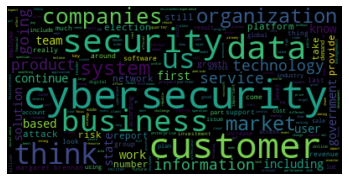

<Figure size 432x288 with 0 Axes>

In [334]:
text = '.'.join(df[df.category=='cybersecurity'].clean_text)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('wordcloud.png')

In [342]:
def fit_model(model, X, y, x_test,y_test, scoring_metric = 'accuracy'):
    model.fit(X,y)
    pred=model.predict(x_test)
    return accuracy_score(pred, y_test), f1_score(pred, y_test, average='macro'), pred

In [482]:

# Import time module
import time
 
# record start time
start = time.time()
fit_model(models['gb'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])


(0.823943661971831,
 0.8057338036616482,
 array([[0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [

In [483]:
end-start

-102.62864303588867

In [480]:
fit_model(models['dt2'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.8873239436619719,
 0.7901999983235682,
 array([[0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        

In [479]:
fit_model(models['dt4'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.8802816901408451,
 0.7556542844453767,
 array([[0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        

In [345]:
fit_model(models['logreg'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.5732484076433121,
 0.6972678299174044,
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]))

In [346]:
fit_model(models['dt'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.8174097664543525,
 0.8288143113857384,
 array([[0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]))

In [347]:
fit_model(models['rf'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.5371549893842887,
 0.6263332051334667,
 array([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1]]))

In [348]:
fit_model(models['knn'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.5520169851380042,
 0.6562030323668486,
 array([[0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1]]))

In [349]:
fit_model(models['knn2'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.6008492569002123,
 0.692960792650846,
 array([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]))

In [350]:
fit_model(models['knn3'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.6369426751592356,
 0.7244347906967212,
 array([[0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]))

In [351]:
fit_model(models['rf2'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.5859872611464968,
 0.6541407468997157,
 array([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1]]))

In [325]:
mapping.keys()

dict_keys(['artificial intelligence', 'cybersecurity', 'blockchain', 'cloud computing', 'electric vehicles'])

In [443]:
acc, f1, pred =fit_model(models['dt3'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

In [445]:
pd.concat([test_data, pd.DataFrame(pred,columns=['artificial intelligence','cybersecurity','blockchain','cloud computing','electric vehicles'])],axis=1).to_csv('test_output_comparison.csv')

In [488]:
fit_model(models['gb2'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.8309859154929577,
 0.8054264284875128,
 array([[0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        

In [485]:
fit_model(models['gb3'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])

(0.8450704225352113,
 0.8253035406226896,
 array([[0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        

In [241]:
acc, f1, pred = fit_model(models['gb2'], data.clean_text, data[[0,1,2,3,4]], test_data.clean_text, test_data[[0,1,2,3,4]])